# Quantization - introduction

In [1]:
import torch
import matplotlib.pyplot as plt
# default size of figures
plt.rcParams['figure.figsize'] = [10, 10]

Quantization is a process of representation change: from real values to discrete space.

Let's start our journey with some data representations!

First, we have **unsigned INT** representations, where we simple denote numbers with following bits (from leftmost most significant bit (MSB) to least significant bit (LSB)).

$1011b = 1*2^3 + 0*2^2 + 1*2^1 + 1*2^0 = 8 + 0 + 2 + 1 = 11$

Then, we have signed **INT** representations, where we use MSB for sign. We most often use so called `Complement Representation` where the first bit is negative value with maximal magnitude.

$1011b = 1 * -(2^4) + 0*2^3 + 1*2^2 + 1*2^1 = -8 + 2 + 1 = -5$

$0011b = 0 * -(2^4) + 0*2^3 + 1*2^2 + 1*2^1 = 2 + 1 = 3$

We can use this approach to represent fractions as well. We use **fixed point** representation, where first digit represents sign (in the same metter as in INT), next couple of bits represent integer part, and remaining bits represent fraction.

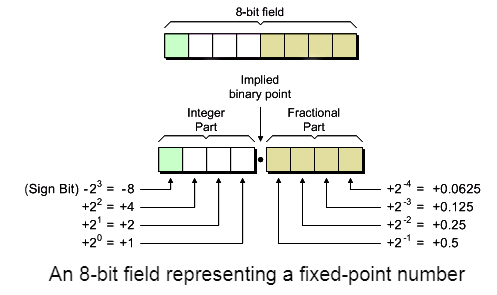

Finally, we have **floating point representations**. We'll use an IEEE-754 32-bit standard, where FP is denoted with:
- sign `S` (most significant bit - leftmost one)
- exponent `E` (following 8 bits)
- fraction `F` (remaining 23 bits)

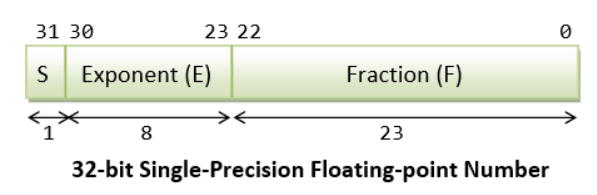

The sign tells us wheater the number is positive (0) or negative (1).
The fraction can be used to represent all the digits after the "dot" (so... the fraction!). It is normalized with leading 1, so it's `1.F`
And finally, we use the exponent to "shift" the decimal point. We use 8 bits for this part of the number, so we can get maximum value of 255. In order to get both very big and very small numbers, we actually normalized as `E-127`

The final number we get can be described as:

$x_{FP} = (-1)^S * 1.F * 2^{E-127}$

Floating point representation has good enough precision to assume it as a real value.

For the first task, let's try out some representations!

1) Calculate the number, that can be represented as the **UINT**: `10110`

2) Calculate the number, that can be represented as the **INT**: `10110`

2) Calculate the number, that can be represented as the **fixed point** with 4 bits integer part and 4 bits fraction part: `1011 0100`

3) Calculate the number, that can be represented as the **floating point**: `11000000101100000000000000000000`

Write your code clearly - implement entire equations!

In [2]:
def binary_to_uint(binary_str):
    decimal_value = int(binary_str, 2)
    return decimal_value

def binary_to_int(binary_str):
    # Check the sign bit (MSB)
    if binary_str[0] == '1':
        # Perform two's complement for negative numbers
        inverted = ''.join('1' if bit == '0' else '0' for bit in binary_str)
        decimal_value = -(int(inverted, 2) + 1)
    else:
        decimal_value = int(binary_str, 2)
    return decimal_value

def binary_to_fixed_point(binary_str, integer_bits, fraction_bits):
    int_part = int(binary_str[:integer_bits], 2)
    fraction_part = sum(int(bit) * 2**(-i - 1) for i, bit in enumerate(binary_str[integer_bits:integer_bits + fraction_bits]))
    decimal_value = int_part + fraction_part
    return decimal_value

def binary_to_float(binary_str):
    sign = (-1) ** int(binary_str[0])
    exponent = int(binary_str[1:9], 2) - 127
    fraction = 1 + sum(int(bit) * 2**(-i - 1) for i, bit in enumerate(binary_str[9:]))
    decimal_value = sign * fraction * 2 ** exponent
    return decimal_value



In [3]:
# Examples of usage:
uint_value = binary_to_uint("10110")
int_value = binary_to_int("10110")
fixed_point_value = binary_to_fixed_point("10110100", 4, 4)
float_value = binary_to_float("11000000101100000000000000000000")

print("UINT:", uint_value)
print("INT:", int_value)
print("Fixed Point:", fixed_point_value)
print("Floating Point:", float_value)


UINT: 22
INT: -10
Fixed Point: 11.25
Floating Point: -5.5


'We have a basics ready, so let's quantize!

We'll start with something easy!
Create a tensor `R1` with values from linear space of range 0 to 16 and length of 1000 elements.

Print this tensor and plot it on both axis X and Y. Add title and legend

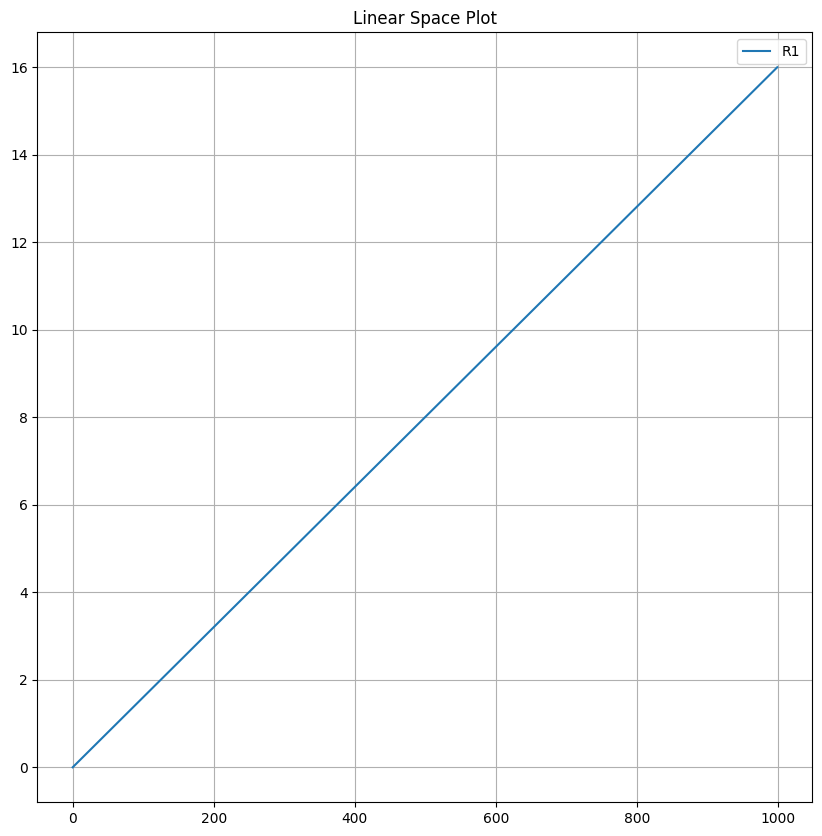

In [4]:
import torch
import matplotlib.pyplot as plt

# Create a tensor R1 with values from a linear space
R1 = torch.linspace(0, 16, 1000)

# Plot the tensor on both axes X and Y
plt.plot(R1, label='R1')

# Set the title and legend
plt.title('Linear Space Plot')
plt.legend()

# Add a grid to the plot
plt.grid()

# Show the plot
plt.show()


Remember, that we use quantisation in case of embedded AI to reduce the precision of weights activations. Our goal is to represent the same numbers with smaller number of bits! Let's represent those floating point numbers as 4bit INTs.

That's easy! Let's just round the numbers with `torch.floor()` function! That's it!

Print `R1` tensor and quantized tensor on the same plot!

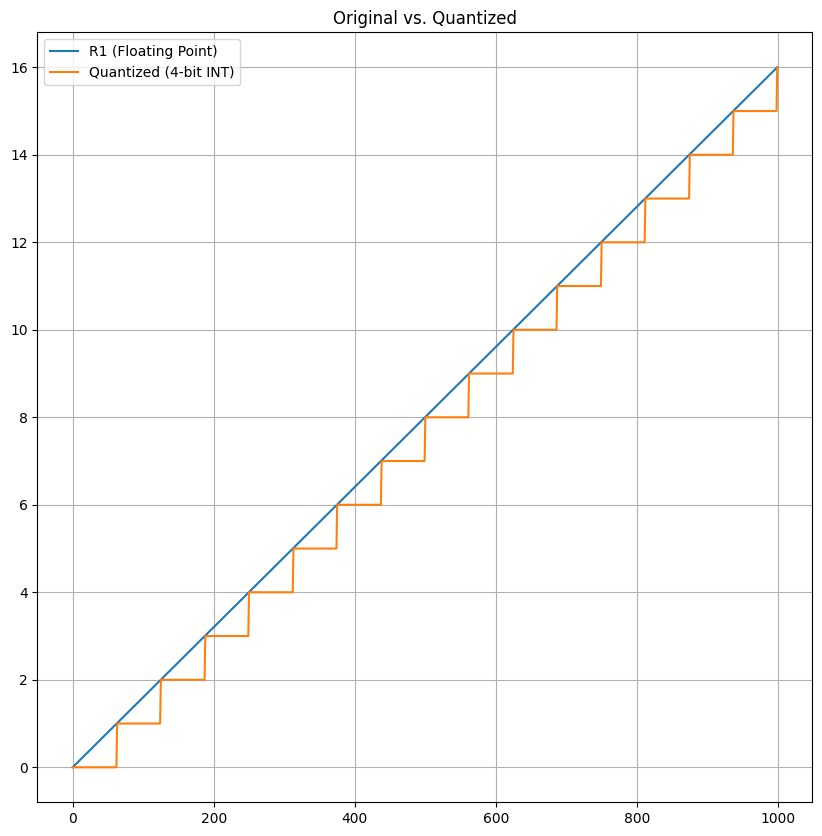

In [5]:
import torch
import matplotlib.pyplot as plt

# Create a tensor R1 with values from a linear space
R1 = torch.linspace(0, 16, 1000)

# Quantize R1 to 4-bit integers using torch.floor()
Q = torch.floor(R1)

# Plot both the original tensor and the quantized tensor
plt.plot(R1, label='R1 (Floating Point)')
plt.plot(Q, label='Quantized (4-bit INT)')

# Set the title and legend
plt.title('Original vs. Quantized')
plt.legend()

# Add a grid to the plot
plt.grid()

# Show the plot
plt.show()

All right. But what if we have different ranges for our data?

 Create a tensor R2 with values from linear space of range -2 to 18 and length of 1000 elements.

With 4bit INT be can not get any number smaller than 0 or bigger than $2^4-1$

Use `torch.clamp()` to limit the numbers.

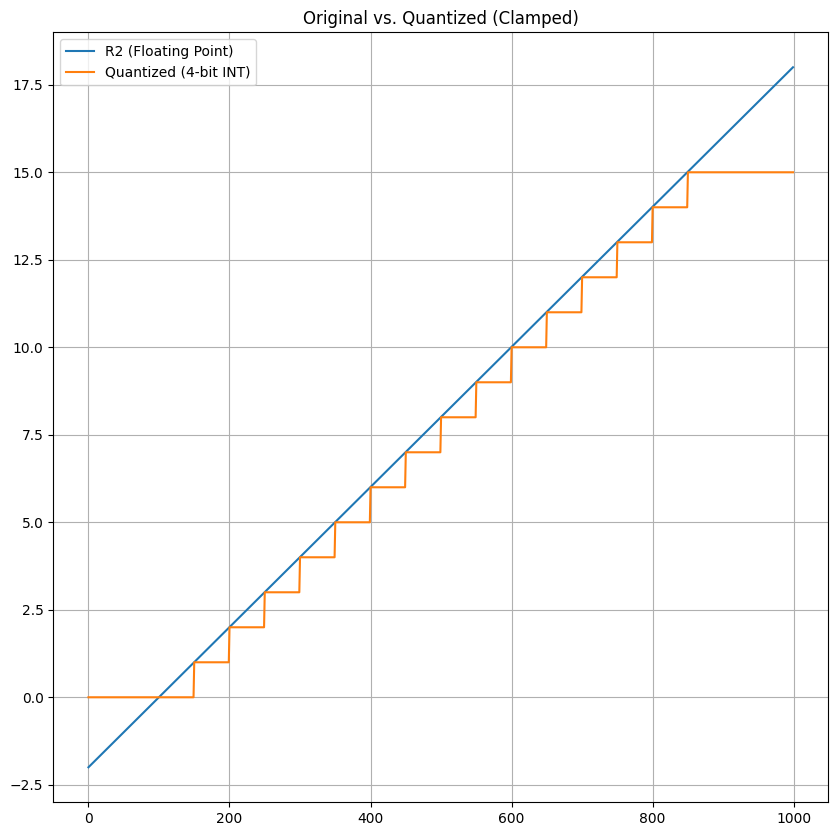

In [6]:
# Create a tensor R2 with values from a linear space
R2 = torch.linspace(-2, 18, 1000)

# Quantize R2 to 4-bit integers using torch.floor()
Q = torch.floor(R2)

# Clamp the quantized values to the range [0, 15] (4-bit INT range)
Q = torch.clamp(Q, 0, 15)

# Plot both the original tensor and the quantized tensor
plt.plot(R2, label='R2 (Floating Point)')
plt.plot(Q, label='Quantized (4-bit INT)')

# Set the title and legend
plt.title('Original vs. Quantized (Clamped)')
plt.legend()

# Add a grid to the plot
plt.grid()

# Show the plot
plt.show()

Ok... But let's say, that we want to represent the fractions as well!
Let's use fixed point representation, that:
- doesn't use sign bit
- has a total of 5 bits
- uses on bit as fraction

Let's study this representation!
Calculate:
- what is the biggest and smallest number, you can represent with this representation?
- Whats the `PRECISION` of this representation (distance between next fixed point numbers).
- How many numbers can we represent on this discrete space (what is the discrete space size)?

Now, in order to quantize our `R1` tensor we need to `scale` it!

The `scale` is the `PRECISION` of this representation.

Divide the `R2` with calculated `scale` before using the floor function.

Then - multiply the result of `floor` function with the same `scale` before appling `clamp`

INT_BITS: 4
PRECISION: 0.5
MIN_VALUE: 0.0
MAX_VALUE: 15.5
DISCRETE_SPACE_SIZE: 32


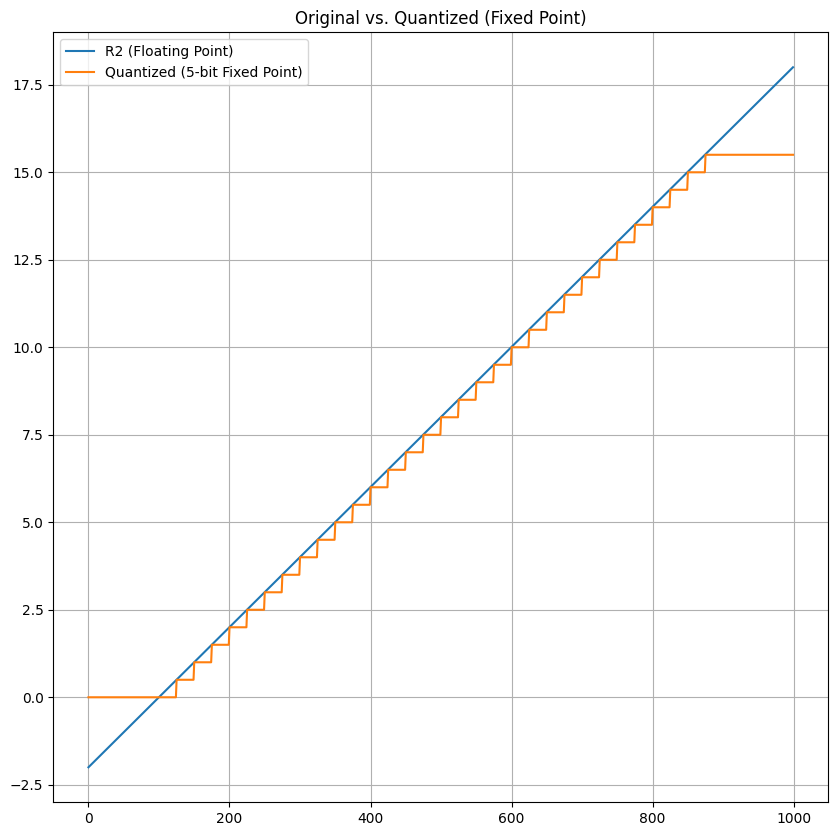

In [8]:
SIGN_BITS = 0
WIDTH_BITS = 5
FRACTION_BITS = 1
INT_BITS = WIDTH_BITS - FRACTION_BITS

PRECISION = 2 ** -FRACTION_BITS
MIN_VALUE = 0.0
MAX_VALUE = (2 ** WIDTH_BITS - 1) * PRECISION
DISCRETE_SPACE_SIZE = 2 ** WIDTH_BITS

print("INT_BITS:", INT_BITS)
print("PRECISION:", PRECISION)
print("MIN_VALUE:", MIN_VALUE)
print("MAX_VALUE:", MAX_VALUE)
print("DISCRETE_SPACE_SIZE:", DISCRETE_SPACE_SIZE)

# Scale R2 before quantization
scale = PRECISION
R2_scaled = R2 / scale

# Quantize R2_scaled to 5-bit fixed-point numbers
Q = torch.floor(R2_scaled)

# Clamp the quantized values back to the fixed-point range
Q = torch.clamp(Q, 0, DISCRETE_SPACE_SIZE - 1)

# Rescale the quantized values to their original range
Q = Q * scale

# Plot both the original tensor and the quantized tensor
plt.plot(R2, label='R2 (Floating Point)')
plt.plot(Q, label='Quantized (5-bit Fixed Point)')

# Set the title and legend
plt.title('Original vs. Quantized (Fixed Point)')
plt.legend()

# Add a grid to the plot
plt.grid()

# Show the plot
plt.show()

For AI, most weights and activations are numbers close to 0 (both positive and negative). We would like to be able to represent negative numbers! So let's try something harder!

Create a tensor R3 with values from linear space of range -2.5 to 2.5 and length of 1000 elements.

As our discrete space, we'll now use fixed point representation with:
- total width of 4 bits
- 1 bit sign
- point position after second bit

Note: bit of sign is one of integer bits!

Let's study this representation!
Calculate:
- the number of bits used to represent the integer part and the fraction.
- what is the biggest and smallest number, you can represent with this representation?
- Whats the precision of this representation (distance between next fixed point numbers).
- How many numbers can we represent on this discrete space (what is the discrete space size)?

In [9]:
# Create a tensor R3 with values from a linear space
R3 = torch.linspace(-2.5, 2.5, 1000)

SIGN_BITS = 1
WIDTH_BITS = 4
FRACTION_BITS = 2
INT_BITS = WIDTH_BITS - SIGN_BITS - FRACTION_BITS

PRECISION = 2 ** -FRACTION_BITS
MIN_VALUE = -2 ** (INT_BITS - 1) * PRECISION  # Smallest value
MAX_VALUE = (2 ** (INT_BITS - 1) - 2 ** -FRACTION_BITS) * PRECISION  # Largest value
DISCRETE_SPACE_SIZE = 2 ** WIDTH_BITS

print("INT_BITS:", INT_BITS)
print("PRECISION:", PRECISION)
print("MIN_VALUE:", MIN_VALUE)
print("MAX_VALUE:", MAX_VALUE)
print("DISCRETE_SPACE_SIZE:", DISCRETE_SPACE_SIZE)


INT_BITS: 1
PRECISION: 0.25
MIN_VALUE: -0.25
MAX_VALUE: 0.1875
DISCRETE_SPACE_SIZE: 16


Try to perform quantization in the same way, as previously!

Calculate the scale, use `floor` and `clamp`!

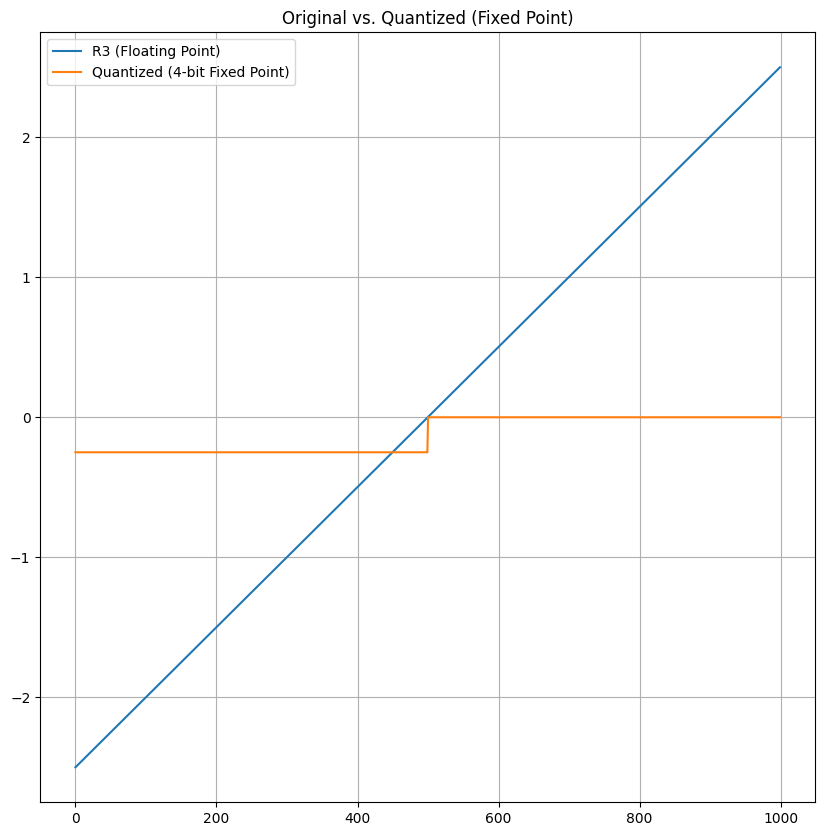

In [10]:
import torch
import matplotlib.pyplot as plt

# Create a tensor R3 with values from a linear space
R3 = torch.linspace(-2.5, 2.5, 1000)

SIGN_BITS = 1
WIDTH_BITS = 4
FRACTION_BITS = 2
INT_BITS = WIDTH_BITS - SIGN_BITS - FRACTION_BITS

PRECISION = 2 ** -FRACTION_BITS
MIN_VALUE = -2 ** (INT_BITS - 1) * PRECISION  # Smallest value
MAX_VALUE = (2 ** (INT_BITS - 1) - 2 ** -FRACTION_BITS) * PRECISION  # Largest value
DISCRETE_SPACE_SIZE = 2 ** WIDTH_BITS

# Calculate the scale
S = PRECISION

# Scale R3 before quantization
R3_scaled = R3 / S

# Quantize R3_scaled to 4-bit fixed-point numbers
Q = torch.floor(R3_scaled)

# Clamp the quantized values back to the fixed-point range
Q = torch.clamp(Q, -2 ** (INT_BITS - 1), 2 ** (INT_BITS - 1) - 1)

# Rescale the quantized values to their original range
Q = Q * S

# Plot both the original tensor and the quantized tensor
plt.plot(R3, label='R3 (Floating Point)')
plt.plot(Q, label='Quantized (4-bit Fixed Point)')

# Set the title and legend
plt.title('Original vs. Quantized (Fixed Point)')
plt.legend()

# Add a grid to the plot
plt.grid()

# Show the plot
plt.show()

Based on the described algorytm, define a function `fixed_point_quantize`.

Function should takes arguments:
- `R` - floating point tensor, which will be quantized
- `bit_width` - fixed point bit width
- `fraction_bits` - number of fraction bits / point position
- `round_method` - method of rounding, one of 'round', 'floor', 'ceil'.

Function should return quantized tensor.

In [11]:
import torch

def signed_fixed_point_quantize(R: torch.Tensor, bit_width: int, fraction_bits: int, round_method: str = 'round') -> torch.Tensor:
    if round_method not in ('round', 'floor', 'ceil'):
        raise ValueError("round_method must be one of 'round', 'floor', or 'ceil'")
    
    int_bits = bit_width - 1 - fraction_bits
    scale = 2.0 ** (-fraction_bits)

    if round_method == 'round':
        quantized = torch.round(R * scale)
    elif round_method == 'floor':
        quantized = torch.floor(R * scale)
    else:
        quantized = torch.ceil(R * scale)

    # Clamp the quantized values
    min_value = -2 ** int_bits if int_bits > 0 else -1
    max_value = 2 ** int_bits - 1
    quantized = torch.clamp(quantized, min_value, max_value)

    return quantized


12. Test function on previously created `R` tensor.

Display both `R` tensor and `quantized` tensor on the same plot.

Try out different rounding methods, print all tensors on the same plot.

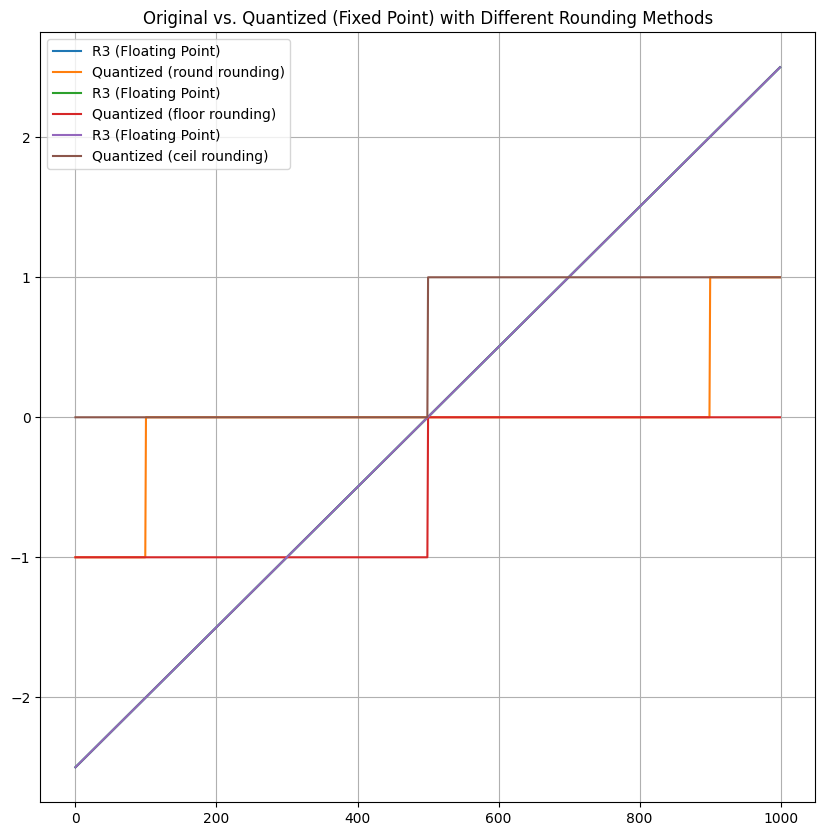

In [12]:
import torch
import matplotlib.pyplot as plt

# Create a tensor R3 with values from a linear space
R3 = torch.linspace(-2.5, 2.5, 1000)

# Define the quantization parameters
bit_width = 4
fraction_bits = 2

# Test the quantization with different rounding methods
rounding_methods = ['round', 'floor', 'ceil']
for round_method in rounding_methods:
    quantized = signed_fixed_point_quantize(R3, bit_width, fraction_bits, round_method)

    # Plot both the original tensor and the quantized tensor
    plt.plot(R3, label='R3 (Floating Point)')
    plt.plot(quantized, label=f'Quantized ({round_method} rounding)')

# Set the title and legend
plt.title('Original vs. Quantized (Fixed Point) with Different Rounding Methods')
plt.legend()

# Add a grid to the plot
plt.grid()

# Show the plot
plt.show()


Apply quantization on image `mandrill.jpg`.

Use opencv function `imread` to read image with arguments: path_to_file and value 0 (as second arg).

Function returns numpy ndarray. Convert it to torch.Tensor and divide by 255 (normalization).

Display image with `plt.imshow`.

Apply signed quantization of 4 bits, 3 bits of precision and 'floor' rounding.

Plot resultant image.


228


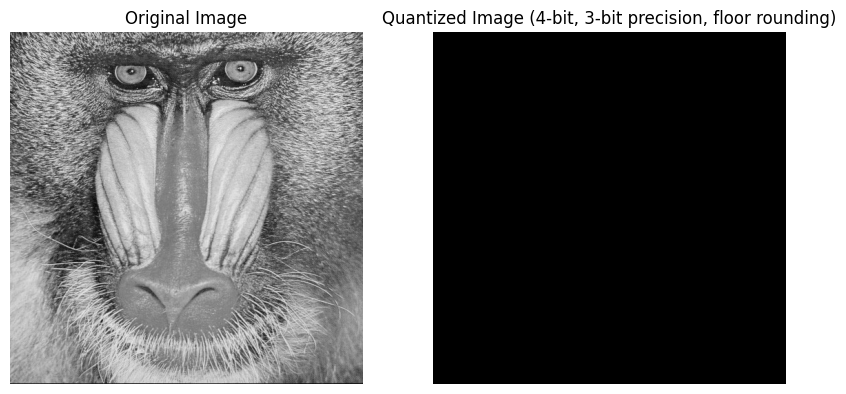

In [20]:
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import numpy as np

# Read the image using OpenCV
image_path = 'mandrill.jpg'
image = cv.imread(image_path, 0)
#print the numver of unique values
image_np=np.array(image)
print("Number of unique values in the image:", len(np.unique(image_np.flatten())))
print("Max and min value in the image",
# Convert the image to a torch.Tensor and normalize it
image = torch.Tensor(image) / 255.0


# Define quantization parameters
bit_width = 4
fraction_bits = 3
round_method = 'floor'

# Apply quantization
quantized_image = signed_fixed_point_quantize(image, bit_width, fraction_bits, round_method)

# Display the original and quantized images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized Image ({bit_width}-bit, {fraction_bits}-bit precision, {round_method} rounding)')
plt.axis('off')

plt.show()


Before we finish, let's consider the case, where we want represent real values with totally different set of numbers.

Create a tensor `R4` with 500 values from linear space of range -2.5 to 0 and 500 values from linear space of range 0 to 10 (you'll need `tensor.cat` function).

Let's represent this tensor with integers in range of 0-15. To do that you use following functions:

$Q(R) = floor(R/S + Z)$

where
- `S` is simply ratio of the input range to the output range
- `Z` is `zero-point` to ensure that the smallest value in input space maps perfectly to smallest value in quantized space


$S = R_{max}-R_{min} / Q_{max}-Q_{min}$

$Z = -(R_{min}/S - Q_{min})$




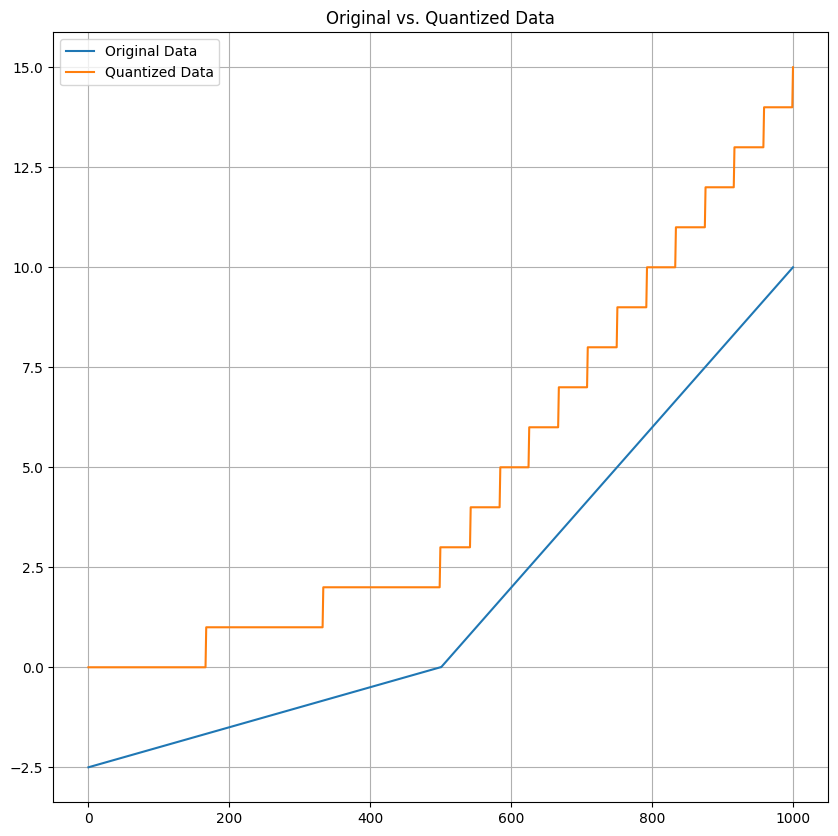

In [15]:
import torch
import matplotlib.pyplot as plt

# Create two tensors and concatenate them
R_temp1 = torch.linspace(-2.5, 0, 500)
R_temp2 = torch.linspace(0, 10, 500)
R4 = torch.cat((R_temp1, R_temp2))

# Reference range
R_ref = torch.linspace(0, 1000, 1000)

# Calculate S (scaling factor) and Z (zero-point)
R_min = R4.min()
R_max = R4.max()
Q_min = 0
Q_max = 15

S = (R_max - R_min) / (Q_max - Q_min)
Z = -(R_min / S - Q_min)

# Quantize R4 using the formula
Q = torch.floor(R4 / S + Z)

# Plot the original and quantized data
plt.plot(R_ref, R4, label='Original Data')
plt.plot(R_ref, Q, label='Quantized Data')
plt.title('Original vs. Quantized Data')
plt.legend()
plt.grid()
plt.show()
